In [1]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
cov = pd.read_csv('cov.csv', parse_dates=['date'])

In [3]:
aqi = pd.read_csv('aqi.csv', parse_dates=['date'])

In [4]:
df = cov.merge(
    aqi,
    on=['province', 'date']
)

In [5]:
df['first_wave'] = df.date <= '2020-07-01'

In [27]:
DFR = None

cols = ['CO', 'NO2', 'NOx', 'O3', 'PM10', 'PM25']

min_shift = 12
max_shift = 42
res = {
    'shift': [],
    'x': [],
    'y': [],
    'fit': [],
    'R2_adj': [],
    'LL': [],
    'AIC': [],
    'coeff': [],
    'F_test': [],
    'standard_error': [],
    'lo': [],
    'hi': [],
}
for shift in tqdm(np.arange(min_shift, max_shift+1)):
    dfr = None
    for pr in sorted(df.province.unique()):
        _df = df[df.province==pr].set_index('date')
        _ic = _df[['incidence_trend']]
        _aq = _df[cols]
        _aq.index = _aq.index + pd.Timedelta(days=shift)
        _aq = _aq[cols]
        _dfr = _ic.merge(_aq, on='date').reset_index()
        _dfr['province'] = pr
        _dfr['first_wave'] = _dfr.date < '2020-08-01'
        
        if dfr is None:
            dfr = _dfr
        else:
            dfr = dfr.append(_dfr, ignore_index=True)
    dfr.loc[dfr.incidence_trend<=0, 'incidence_trend'] = np.nan
    for col in cols:
        dfr.loc[dfr[col]<=0, col] = np.nan
    dfr.dropna(inplace=True)
    dfr['shift'] = shift
    if DFR is None:
        DFR = dfr
    else:
        DFR = DFR.append(dfr, ignore_index=True)

    for j, x in enumerate(cols):
        mod = sm.OLS.from_formula(
            f'np.log(incidence_trend) ~ np.log({x}) + first_wave * province',
            data=dfr
        )
        _x = f"np.log({x})"
        fit = mod.fit()
        res['shift'].append(shift)
        res['x'].append(x)
        res['y'].append(np.log(dfr.incidence_trend.values))
        res['fit'].append(fit)
        res['R2_adj'].append(fit.rsquared_adj)
        res['LL'].append(fit.llf)
        res['AIC'].append(fit.aic)
        res['coeff'].append(fit.params[_x])
        res['F_test'].append(fit.fvalue)
        res['standard_error'].append(fit.bse[_x])
        conf_int = fit.conf_int(alpha=.01)
        res['lo'].append(conf_int.loc[_x, 0])
        res['hi'].append(conf_int.loc[_x, 1])

In [28]:
DFR

,date,incidence_trend,CO,NO2,NOx,O3,PM10,PM25,province,first_wave,shift
0,2020-03-08,17.945355,535.000000,26.068333,41.550833,37.785833,34.850000,27.733333,Bergamo,True,12
1,2020-03-09,20.613953,541.666667,26.130833,41.831667,37.109583,36.283333,28.250000,Bergamo,True,12
2,2020-03-10,22.496152,538.333333,26.215000,41.235000,37.724583,35.883333,28.250000,Bergamo,True,12
3,2020-03-11,27.111409,528.333333,25.849167,41.516667,38.353333,35.383333,28.283333,Bergamo,True,12
4,2020-03-12,31.185211,516.666667,25.090833,41.375000,38.510000,35.666667,28.083333,Bergamo,True,12
...,...,...,...,...,...,...,...,...,...,...,...
103734,2020-12-27,18.420660,513.333333,27.046667,53.522500,20.681250,39.625000,30.375000,Varese,False,42
103735,2020-12-28,23.473830,511.666667,27.280000,53.340000,20.731667,43.633333,30.575000,Varese,False,42
103736,2020-12-29,23.570696,508.333333,27.220000,52.662500,21.060417,43.400000,30.325000,Varese,False,42
103737,2020-12-30,19.227876,510.000000,27.190833,52.732500,21.061667,38.875000,30.000000,Varese,False,42


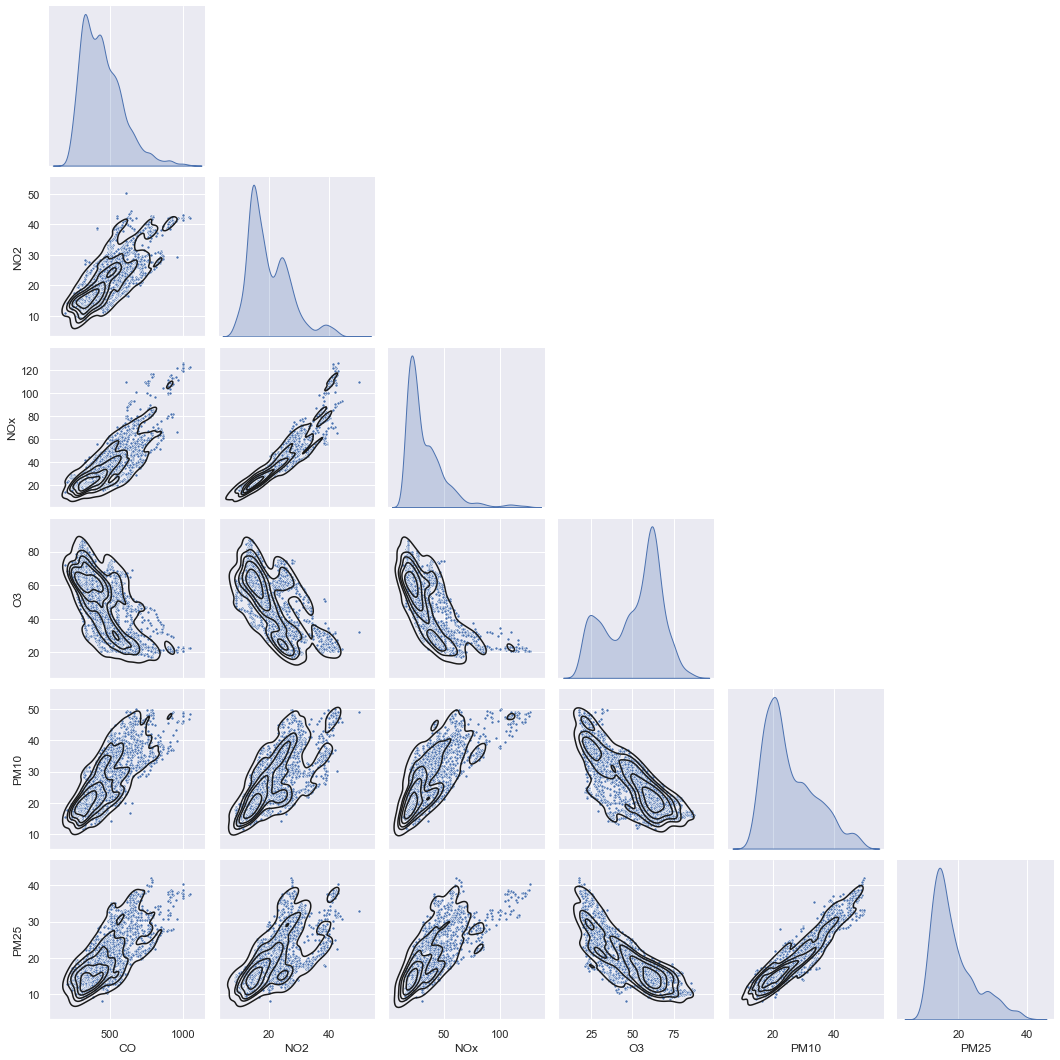

In [15]:
g = sns.pairplot(
    diag_kind="kde",
    data=df[cols],
    corner=True,
    plot_kws=dict(marker=".", lw=.2),
)
g.map_lower(sns.kdeplot, levels=6, color=".1")
g.fig.savefig('images/features_pairplot.png')
plt.show()

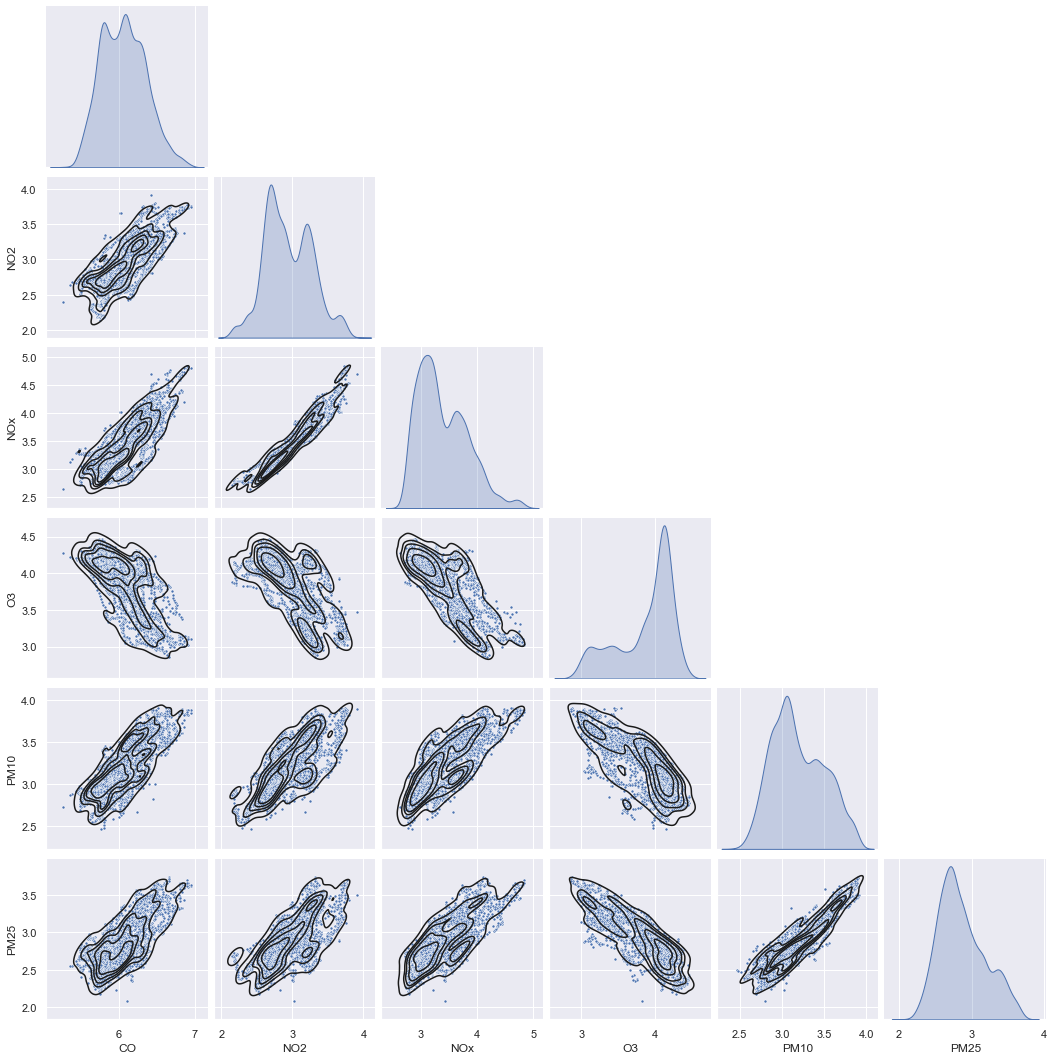

In [16]:
g = sns.pairplot(
    diag_kind="kde",
    data=np.log(df[cols]),
    corner=True,
    plot_kws=dict(marker=".", lw=.2),
)
g.map_lower(sns.kdeplot, levels=6, color=".1")
g.fig.savefig('images/features_log_pairplot.png')
plt.show()

TypeError: suptitle() takes 2 positional arguments but 3 were given

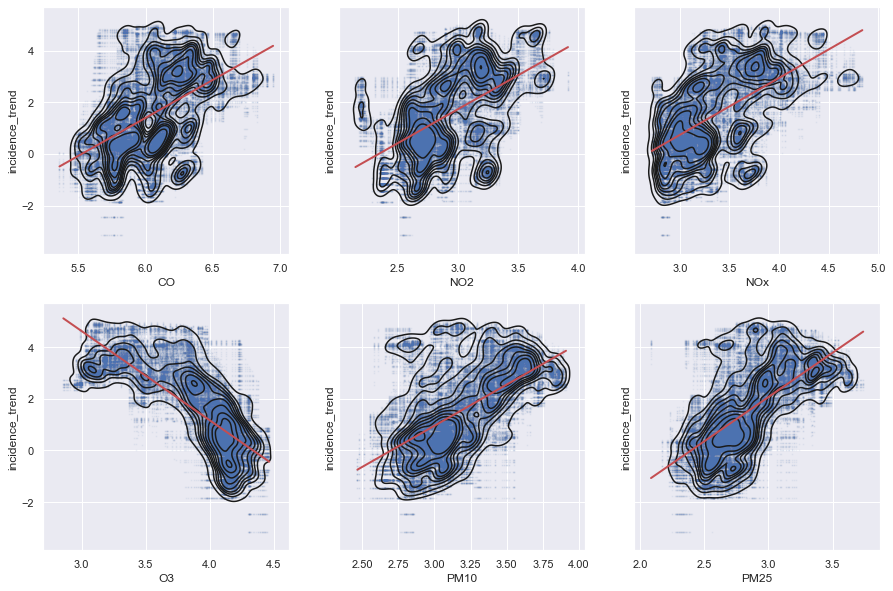

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
for i, x in tqdm(enumerate(cols)):
    ax = axs.flat[i]
    sns.regplot(
        data=np.log(DFR[['incidence_trend', x]]),
        x=x, y='incidence_trend',
        ci=None,
        ax=ax,
        line_kws=dict(color='r', lw=2),
        scatter_kws=dict(marker='.', s=1, alpha=.05)
    )
    sns.kdeplot(
        data=np.log(DFR[['incidence_trend', x]]),
        x=x, y='incidence_trend',
        color='k',
        ax=ax,
    )
fig.suptitle(
    'Correlation between log pollutants values and log COVID-19 provincial incidence trend in Lombardy 2020\n'
    'within the infection-to-diagnosis-communication time interval'
)
fig.savefig('images/correlation_EDA.png')
plt.show()

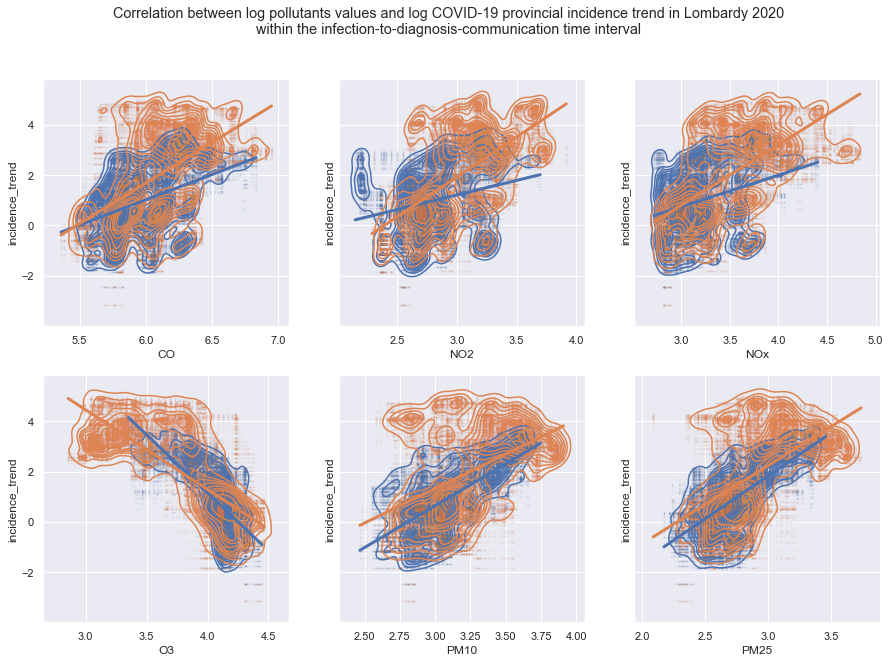

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
for i, x in enumerate(tqdm(cols)):
    ax = axs.flat[i]
    sns.regplot(
        data=np.log(DFR[DFR.first_wave==True][['incidence_trend', x]]),
        x=x, y='incidence_trend',
        ci=None,
        ax=ax,
        line_kws=dict(lw=3),
        scatter_kws=dict(marker='.', s=1, alpha=.05)
    )
    sns.regplot(
        data=np.log(DFR[DFR.first_wave==False][['incidence_trend', x]]),
        x=x, y='incidence_trend',
        ci=None,
        ax=ax,
        line_kws=dict(lw=3),
        scatter_kws=dict(marker='.', s=1, alpha=.05)
    )

    sns.kdeplot(
        data=np.log(DFR[DFR.first_wave==True][['incidence_trend', x]]),
        x=x, y='incidence_trend',
        color='C0',
        ax=ax,
    )
    sns.kdeplot(
        data=np.log(DFR[DFR.first_wave==False][['incidence_trend', x]]),
        x=x, y='incidence_trend',
        color='C1',
        ax=ax,
    )

fig.suptitle(
    'Correlation between log pollutants values and log COVID-19 provincial incidence trend in Lombardy 2020\n'
    'within the infection-to-diagnosis-communication time interval'
)
fig.savefig('images/correlation_EDA_waves.png')
plt.show()

In [32]:
fig.suptitle(
    'Correlation between log pollutants values and log COVID-19 provincial incidence trend in Lombardy 2020\n'
    'within the infection-to-diagnosis-communication time interval'
)


In [160]:
res_df = pd.DataFrame(res)

In [161]:
res_df

,shift,x,y,fit,R2_adj,LL,AIC,coeff,F_test,standard_error,lo,hi
0,12,CO,"[2.8873312985738098, 3.025968170513399, 3.1133...",<statsmodels.regression.linear_model.Regressio...,0.514465,-5361.010617,10772.021233,5.448352,154.904691,0.098965,5.193295,5.703409
1,12,NO2,"[2.8873312985738098, 3.025968170513399, 3.1133...",<statsmodels.regression.linear_model.Regressio...,0.460170,-5545.826362,11141.652723,4.956383,124.816371,0.101642,4.694426,5.218341
2,12,NOx,"[2.8873312985738098, 3.025968170513399, 3.1133...",<statsmodels.regression.linear_model.Regressio...,0.481431,-5475.771138,11001.542276,3.497449,135.847815,0.068364,3.321258,3.673641
3,12,O3,"[2.8873312985738098, 3.025968170513399, 3.1133...",<statsmodels.regression.linear_model.Regressio...,0.693433,-4559.321288,9168.642575,-3.976325,329.546014,0.048145,-4.100406,-3.852244
4,12,PM10,"[2.8873312985738098, 3.025968170513399, 3.1133...",<statsmodels.regression.linear_model.Regressio...,0.537412,-5276.598964,10603.197928,4.742324,169.744622,0.081899,4.531251,4.953397
...,...,...,...,...,...,...,...,...,...,...,...,...
181,42,NO2,"[2.3774630707641466, 2.1561121700644565, 2.040...",<statsmodels.regression.linear_model.Regressio...,0.558090,-4777.260870,9604.521740,5.520847,167.808263,0.102603,5.256399,5.785296
182,42,NOx,"[2.3774630707641466, 2.1561121700644565, 2.040...",<statsmodels.regression.linear_model.Regressio...,0.540627,-4838.705615,9727.411230,3.976121,156.446545,0.077012,3.777630,4.174611
183,42,O3,"[2.3774630707641466, 2.1561121700644565, 2.040...",<statsmodels.regression.linear_model.Regressio...,0.562045,-4763.006930,9576.013860,-3.457144,170.507470,0.063653,-3.621203,-3.293085
184,42,PM10,"[2.3774630707641466, 2.1561121700644565, 2.040...",<statsmodels.regression.linear_model.Regressio...,0.552811,-4796.086808,9642.173616,4.857096,164.280266,0.091400,4.621522,5.092670


In [162]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(incidence_trend)   R-squared:                       0.570
Model:                                 OLS   Adj. R-squared:                  0.567
Method:                      Least Squares   F-statistic:                     173.8
Date:                     Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                             13:11:26   Log-Likelihood:                -4745.9
No. Observations:                     3171   AIC:                             9542.
Df Residuals:                         3146   BIC:                             9693.
Df Model:                               24                                         
Covariance Type:                 nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                              -11.6614      0.254    -45.948      0.000     -12.159     -11.164
first_wave[T.True]                                       0.0111      0.134      0.083      0.934      -0.251       0.273
province[T.Brescia]                                      0.4294      0.124      3.461      0.001       0.186       0.673
province[T.Como]                                         0.5871      0.126      4.667      0.000       0.340       0.834
province[T.Cremona]                                     -0.8579      0.126     -6.833      0.000      -1.104      -0.612
province[T.Lecco]                                        2.1870      0.128     17.093      0.000       1.936       2.438
province[T.Lodi]                                         0.5988      0.124      4.826      0.000       0.356       0.842
province[T.Mantova]                                      1.1181      0.124      9.000      0.000       0.874       1.362
province[T.Milano]                                       0.5760      0.124      4.629      0.000       0.332       0.820
province[T.Monza e della Brianza]                        0.7158      0.127      5.639      0.000       0.467       0.965
province[T.Pavia]                                        0.4359      0.124      3.505      0.000       0.192       0.680
province[T.Sondrio]                                      1.5593      0.127     12.317      0.000       1.311       1.808
province[T.Varese]                                       1.3235      0.124     10.635      0.000       1.080       1.568
first_wave[T.True]:province[T.Brescia]                  -0.9354      0.189     -4.950      0.000      -1.306      -0.565
first_wave[T.True]:province[T.Como]                     -1.3010      0.192     -6.785      0.000      -1.677      -0.925
first_wave[T.True]:province[T.Cremona]                  -0.1442      0.189     -0.763      0.446      -0.515       0.226
first_wave[T.True]:province[T.Lecco]                    -1.3509      0.189     -7.151      0.000      -1.721      -0.981
first_wave[T.True]:province[T.Lodi]                     -0.3036      0.189     -1.605      0.109      -0.675       0.067
first_wave[T.True]:province[T.Mantova]                  -1.0663      0.189     -5.641      0.000      -1.437      -0.696
first_wave[T.True]:province[T.Milano]                   -1.1111      0.190     -5.837      0.000      -1.484      -0.738
first_wave[T.True]:province[T.Monza e della Brianza]    -1.3979      0.195     -7.167      0.000      -1.780      -1.015
first_wave[T.True]:province[T.Pavia]                    -0.8614      0.189     -4.553      0.000      -1.232      -0.490
fir

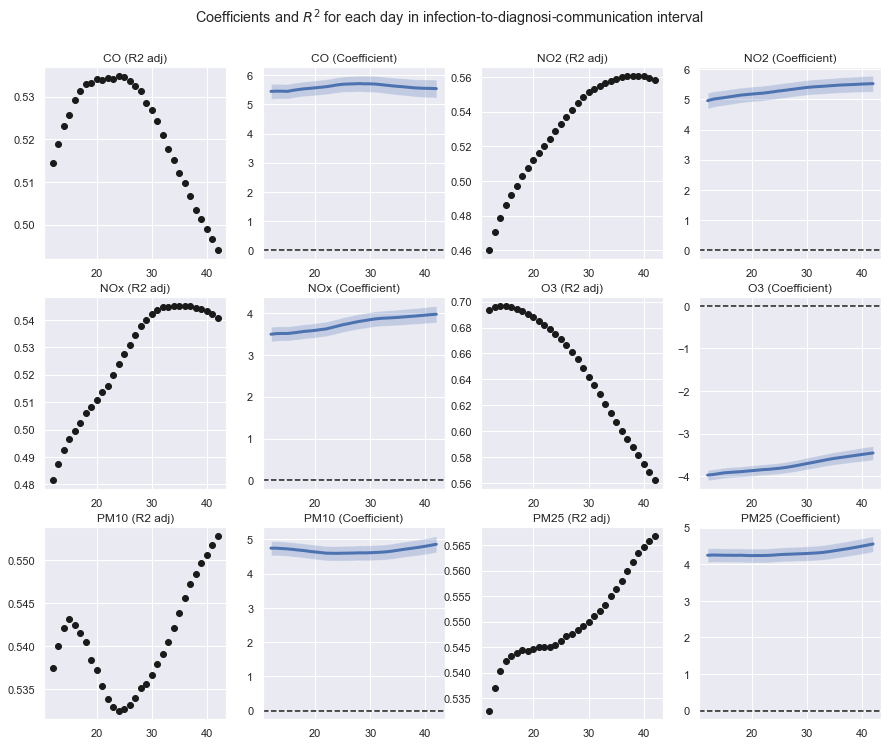

In [163]:
fig, axs = plt.subplots(3, 4, figsize=(15, 12))

for i, x in enumerate(sorted(res_df.x.unique())):
    ax0 = axs.flat[i*2]
    ax1 = axs.flat[i*2+1]
    _df = res_df[res_df.x==x]
    
    _df.plot(
        x='shift', y='R2_adj', title=f"{x} (R2 adj)", marker='o', ls='none', color='k', ax=ax0, legend=False,
        #xlabel='days from infection to diagnosis communication',
        xlabel=''
    )
    _df.plot(
        x='shift', y='coeff', color='b', lw=3, ax=ax1, title=f"{x} (Coefficient)", legend=False,
        #xlabel='days from infection to diagnosis communication'
        xlabel=''
    )
    ax1.fill_between(
        _df['shift'],
        _df.lo, _df.hi,
        alpha=.25
    )
    ax1.axhline(0, color='k', ls='--')
fig.suptitle('Coefficients and $R^2$ for each day in infection-to-diagnosi-communication interval', y=.95)
fig.savefig(f"images/coefficients_R2.png")
plt.show()

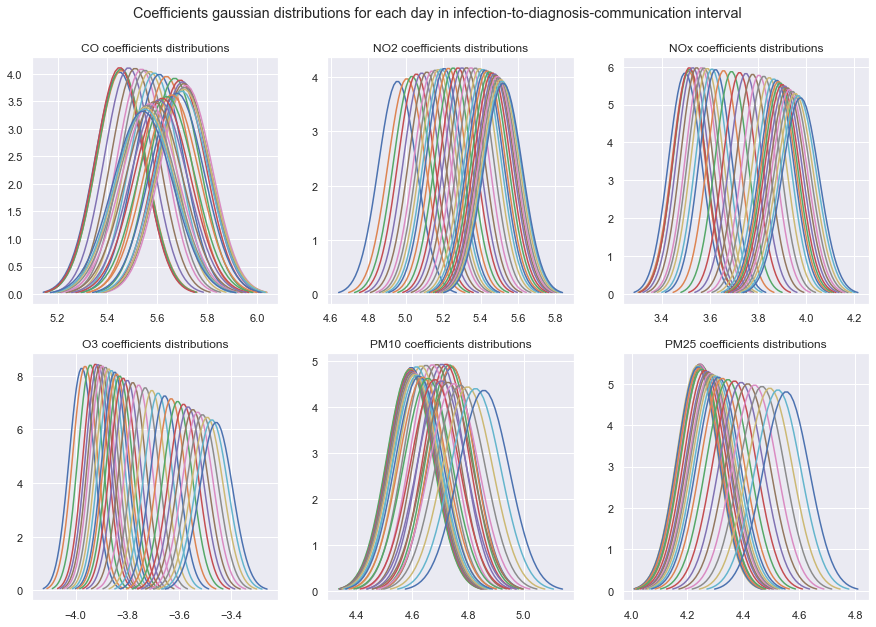

In [164]:
coeff_samples = {
    'x': [],
    'val': [],
}

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, x in enumerate(res_df.x.unique()):
    ax = axs.flat[i]
    _df = res_df[res_df.x==x]
    
    for sh in _df['shift'].unique():
        __df = _df[_df['shift']==sh]
        
        loc = __df.coeff.values[0]
        scale = __df.standard_error.values[0]
        dist = sps.norm(loc=loc, scale=scale)
        
        dx = np.linspace(dist.ppf(.001), dist.ppf(.999))
        dy = dist.pdf(dx)
        ax.plot(dx, dy)
        
        sample = dist.rvs(10000)
        coeff_samples['x'] = np.concatenate((coeff_samples['x'], np.repeat(x, 10000)))
        coeff_samples['val'] = np.concatenate((coeff_samples['val'], sample))
    ax.set(
        title=f"{x} coefficients distributions",
        xlabel=''
    )
fig.suptitle(
    'Coefficients gaussian distributions for each day in infection-to-diagnosis-communication interval',
    y=.95
)
fig.savefig(f"images/distributions.png")
plt.show()

In [165]:
coeff_samples_df = pd.DataFrame(coeff_samples)

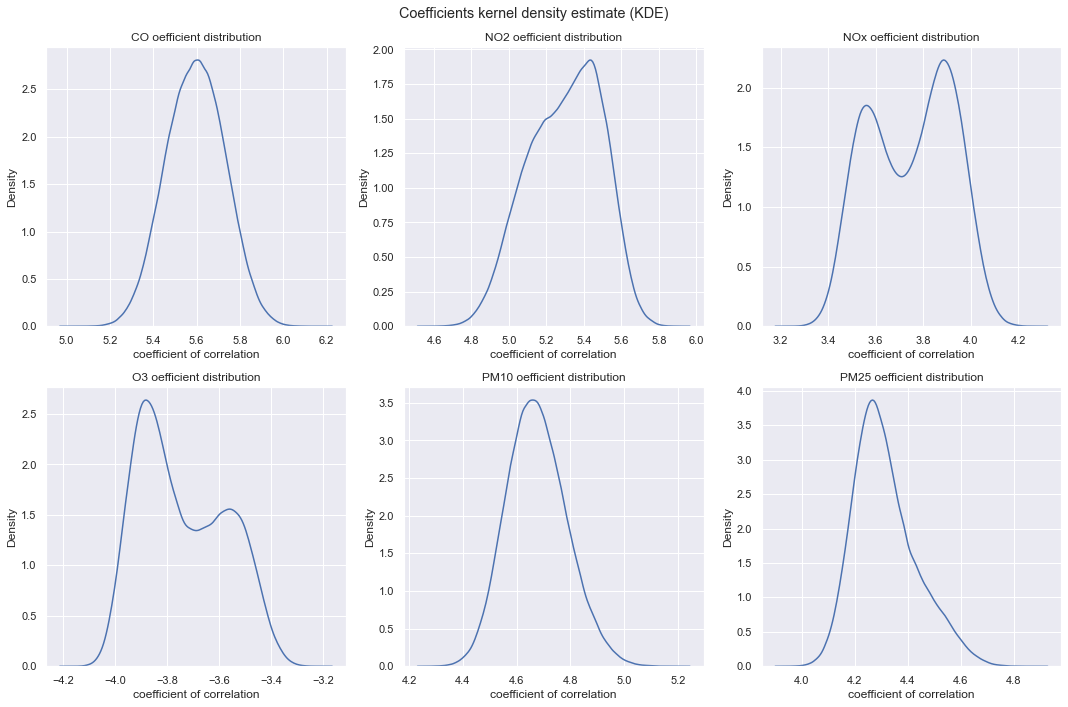

In [166]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, x in enumerate(coeff_samples_df.x.unique()):
    ax = axs.flat[i]
    _df = coeff_samples_df[coeff_samples_df.x==x]
    g = sns.kdeplot(_df.val, ax=ax)
    ax.set(
        title=f"{x} oefficient distribution",
        xlabel='coefficient of correlation'
    )
fig.suptitle("Coefficients kernel density estimate (KDE)", y=.98)
fig.tight_layout()
fig.savefig(f"images/coefficients_distribution.png")
plt.show()

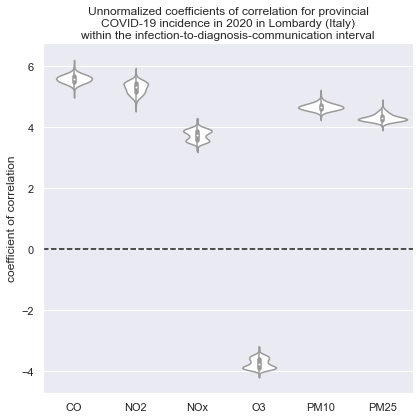

In [167]:
g = sns.catplot(
    kind='violin',
    data=coeff_samples_df,
    x='x', y='val',
    color='white', saturation=1,
    aspect=1, height=6,
)
ax = g.axes.flat[0]
ax.axhline(0, color='k', ls='--')
ax.set(
    ylabel='coefficient of correlation',
    xlabel=None,
    title="Unnormalized coefficients of correlation for provincial\n"
    "COVID-19 incidence in 2020 in Lombardy (Italy)\n"
    "within the infection-to-diagnosis-communication interval"
)
g.fig.tight_layout()
g.fig.savefig(f"images/coefficients_unnormalized.png")
plt.show()

In [168]:
std_devs = {
    'x': [],
    'std_dev': []
}
for x in cols:
    s = np.log(df[x]).std()
    std_devs['x'].append(x)
    std_devs['std_dev'].append(s)
std_devs = pd.DataFrame(std_devs).set_index('x')

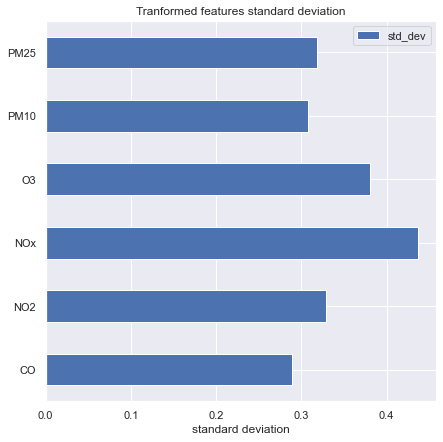

In [169]:
fig, ax = plt.subplots(figsize=(7, 7))
std_devs.plot(kind='barh', ax=ax)
ax.set(
    title='Tranformed features standard deviation',
    ylabel=None,
    xlabel='standard deviation'
)
fig.savefig('images/features_standard_deviation.png')
plt.show()

In [170]:
for x in coeff_samples_df.x.unique():
    _df = coeff_samples_df[coeff_samples_df.x==x]
    _s = std_devs.loc[x, 'std_dev']
    _n = _df.val * _s
    coeff_samples_df.loc[coeff_samples_df.x==x, 'normalized'] = _n.values

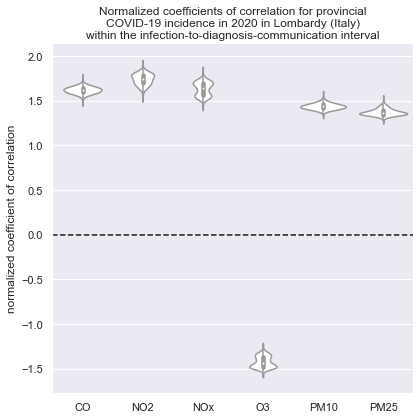

In [171]:
g = sns.catplot(
    kind='violin',
    data=coeff_samples_df,
    x='x', y='normalized',
    color='white', saturation=1,
    aspect=1, height=6,
)
ax = g.axes.flat[0]
ax.axhline(0, color='k', ls='--')
ax.set(
    ylabel='normalized coefficient of correlation',
    xlabel=None,
    title="Normalized coefficients of correlation for provincial\n"
    "COVID-19 incidence in 2020 in Lombardy (Italy)\n"
    "within the infection-to-diagnosis-communication interval"
)
g.fig.tight_layout()
g.fig.savefig(f"images/coefficients_normalized.png")
plt.show()

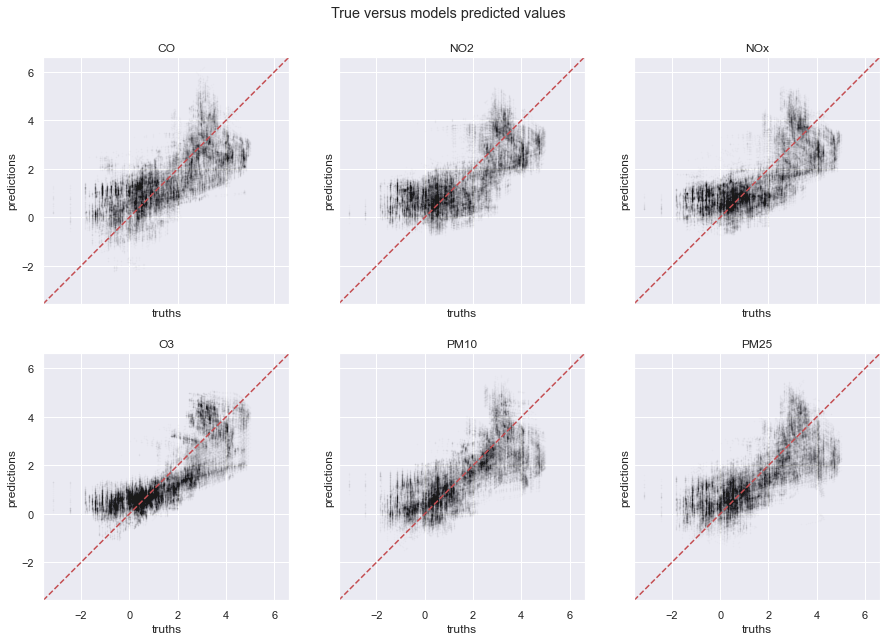

In [172]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for i, x in enumerate(res_df.x.unique()):
    _df = res_df[res_df.x==x]
    for s in _df['shift'].unique():
        __df = _df[_df['shift']==s]
        fit = __df.fit.values[0]
        truths = __df.y.values[0]
        predictions = fit.predict()
        ax.flat[i].plot(truths, predictions, marker='.', ms=1, color='k', ls='none', alpha=.01)
    _lim_min = np.min([ax.flat[i].get_xlim()[0], ax.flat[i].get_ylim()[0]])
    _lim_max = np.max([ax.flat[i].get_xlim()[1], ax.flat[i].get_ylim()[1]])
    ax.flat[i].axline(xy1=(_lim_min, _lim_min), slope=1, ls='--', color='r')
    ax.flat[i].set(
        xlim=(_lim_min, _lim_max),
        ylim=(_lim_min, _lim_max),
        title=x,
        xlabel='truths', ylabel='predictions'
    )
fig.suptitle('True versus models predicted values', y=.95)
fig.savefig('images/truths_predicted.png')
plt.show()

***

In [209]:
log_all = " + ".join(f"np.log({x})" for x in cols)
log_all

'np.log(CO) + np.log(NO2) + np.log(NOx) + np.log(O3) + np.log(PM10) + np.log(PM25)'

In [211]:
from itertools import combinations

comb = combinations(cols, 2)

interact = []

for c in list(comb):
    inter = f"np.log({c[0]}) * np.log({c[1]})"
    interact.append(inter)

In [216]:
log_all = log_all + " + " + " + ".join(interact)

In [217]:
res2 = {
    'shift': [],
    'y': [],
    'fit': [],
    'R2_adj': [],
    'LL': [],
    'AIC': [],
    'F_test': [],
    'params': [],
}
for shift in tqdm(np.arange(min_shift, max_shift+1)):
    dfr = None
    for pr in sorted(df.province.unique()):
        _df = df[df.province==pr].set_index('date')
        _ic = _df[['incidence_trend']]
        _aq = _df[cols]
        _aq.index = _aq.index + pd.Timedelta(days=shift)
        _aq = _aq[cols]
        _dfr = _ic.merge(_aq, on='date').reset_index()
        _dfr['province'] = pr
        _dfr['first_wave'] = _dfr.date < '2020-07-01'
        
        if dfr is None:
            dfr = _dfr
        else:
            dfr = dfr.append(_dfr, ignore_index=True)
    dfr.loc[dfr.incidence_trend<=0, 'incidence_trend'] = np.nan
    for col in cols:
        dfr.loc[dfr[col]<=0, col] = np.nan
    dfr.dropna(inplace=True)

    mod = sm.OLS.from_formula(
        f'np.log(incidence_trend) ~ {log_all} + first_wave * province',
        data=dfr
    )
    fit = mod.fit()
    res2['shift'].append(shift)
    res2['fit'].append(fit)
    res2['R2_adj'].append(fit.rsquared_adj)
    res2['LL'].append(fit.llf)
    res2['AIC'].append(fit.aic)
    res2['y'].append(np.log(dfr.incidence_trend.values))
    res2['F_test'].append(fit.fvalue)
    Xs = {
        'x': [],
        'coeff': [],
        'standard_error': [],
        'lo': [],
        'hi': [],
    }
    for x in cols:
        _x = f"np.log({x})"
        Xs['x'].append(x)
        Xs['coeff'].append(fit.params[_x])
        Xs['standard_error'].append(fit.bse[_x])
        conf_int = fit.conf_int(alpha=.01)
        Xs['lo'].append(conf_int.loc[_x, 0])
        Xs['hi'].append(conf_int.loc[_x, 1])
    Xs = pd.DataFrame(Xs)
    res2['params'].append(Xs)

In [218]:
res2_df = pd.DataFrame(res2)

In [226]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(incidence_trend)   R-squared:                       0.730
Model:                                 OLS   Adj. R-squared:                  0.726
Method:                      Least Squares   F-statistic:                     191.9
Date:                     Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                             14:47:14   Log-Likelihood:                -4009.4
No. Observations:                     3171   AIC:                             8109.
Df Residuals:                         3126   BIC:                             8382.
Df Model:                               44                                         
Covariance Type:                 nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               19.0656     23.548      0.810      0.418     -27.105      65.236
first_wave[T.True]                                      -0.2366      0.131     -1.808      0.071      -0.493       0.020
province[T.Brescia]                                     -0.2068      0.099     -2.083      0.037      -0.402      -0.012
province[T.Como]                                        -0.6881      0.144     -4.795      0.000      -0.970      -0.407
province[T.Cremona]                                     -1.0143      0.106     -9.551      0.000      -1.223      -0.806
province[T.Lecco]                                        2.3445      0.117     20.000      0.000       2.115       2.574
province[T.Lodi]                                         0.0393      0.109      0.361      0.718      -0.174       0.253
province[T.Mantova]                                      0.6732      0.119      5.641      0.000       0.439       0.907
province[T.Milano]                                       0.3919      0.208      1.883      0.060      -0.016       0.800
province[T.Monza e della Brianza]                        0.0897      0.185      0.484      0.628      -0.274       0.453
province[T.Pavia]                                       -0.2862      0.147     -1.952      0.051      -0.574       0.001
province[T.Sondrio]                                      0.2805      0.169      1.662      0.097      -0.050       0.611
province[T.Varese]                                       0.2879      0.123      2.333      0.020       0.046       0.530
first_wave[T.True]:province[T.Brescia]                  -0.2314      0.171     -1.355      0.175      -0.566       0.103
first_wave[T.True]:province[T.Como]                      0.0982      0.177      0.555      0.579      -0.248       0.445
first_wave[T.True]:province[T.Cremona]                   0.0552      0.168      0.329      0.742      -0.274       0.384
first_wave[T.True]:province[T.Lecco]                    -0.6086      0.173     -3.513      0.000      -0.948      -0.269
first_wave[T.True]:province[T.Lodi]                      0.0184      0.168      0.109      0.913      -0.312       0.349
first_wave[T.True]:province[T.Mantova]                  -0.8353      0.179     -4.656      0.000      -1.187      -0.484
first_wave[T.True]:province[T.Milano]                   -0.2215      0.180     -1.231      0.218      -0.574       0.131
first_wave[T.True]:province[T.Monza e della Brianza]    -0.7263      0.204     -3.558      0.000      -1.127      -0.326
first_wave[T.True]:province[T.Pavia]                     0.2962      0.181      1.633      0.103      -0.059       0.652
fir

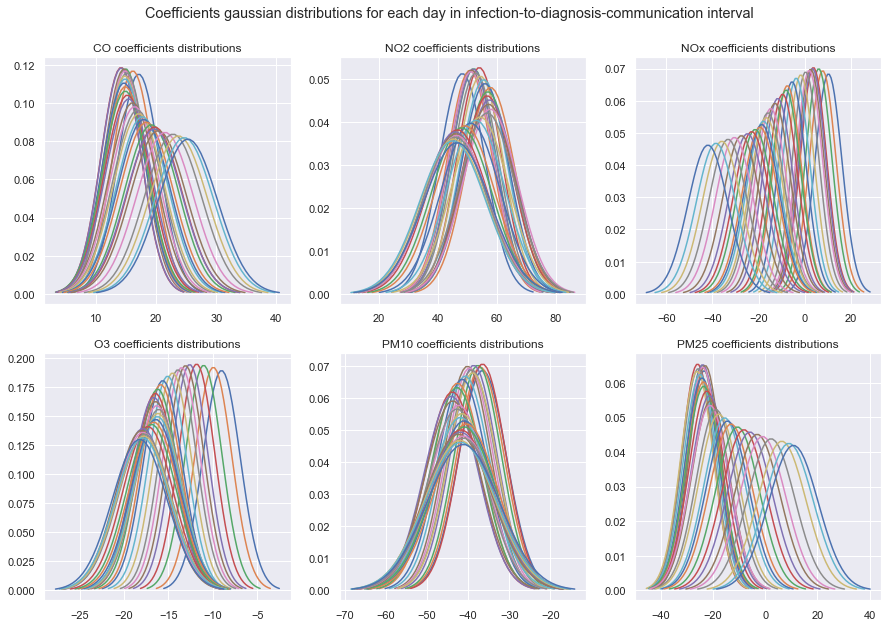

In [219]:
coeff_samples2 = {
    'x': [],
    'val': [],
}

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, x in enumerate(cols):
    ax = axs.flat[i]
    
    for sh in res2_df['shift'].unique():
        _df = res2_df[res2_df['shift']==sh].params.values[0]
        __df = _df[_df.x==x]
        
        loc = __df.coeff.values[0]
        scale = __df.standard_error.values[0]
        dist = sps.norm(loc=loc, scale=scale)
        
        dx = np.linspace(dist.ppf(.001), dist.ppf(.999))
        dy = dist.pdf(dx)
        ax.plot(dx, dy)
        
        sample = dist.rvs(10000)
        coeff_samples2['x'] = np.concatenate((coeff_samples2['x'], np.repeat(x, 10000)))
        coeff_samples2['val'] = np.concatenate((coeff_samples2['val'], sample))
    ax.set(
        title=f"{x} coefficients distributions",
        xlabel=''
    )
fig.suptitle(
    'Coefficients gaussian distributions for each day in infection-to-diagnosis-communication interval',
    y=.95
)
fig.savefig(f"images/all_distributions.png")
plt.show()

In [221]:
coeff_samples2_df = pd.DataFrame(coeff_samples2)

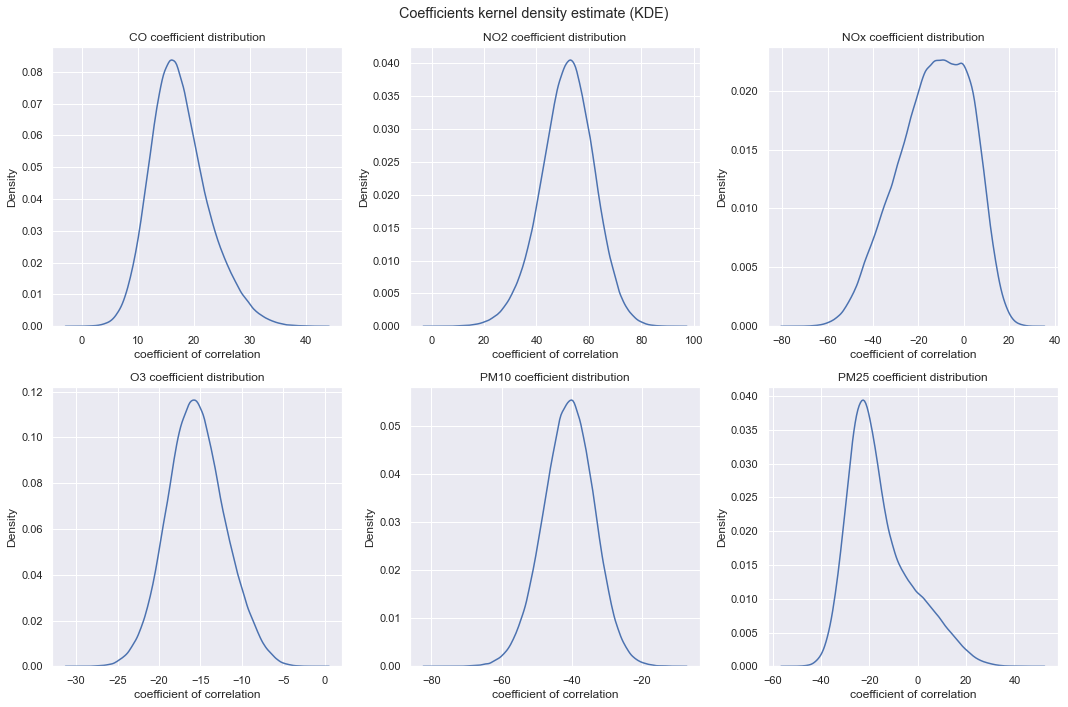

In [222]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, x in enumerate(coeff_samples2_df.x.unique()):
    ax = axs.flat[i]
    _df = coeff_samples2_df[coeff_samples2_df.x==x]
    g = sns.kdeplot(_df.val, ax=ax)
    ax.set(
        title=f"{x} coefficient distribution",
        xlabel='coefficient of correlation'
    )
fig.suptitle("Coefficients kernel density estimate (KDE)", y=.98)
fig.tight_layout()
fig.savefig(f"images/all_coefficients_distribution.png")
plt.show()

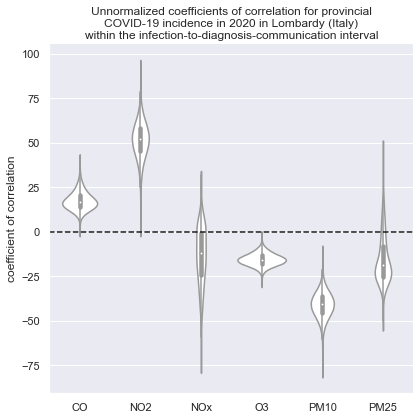

In [223]:
g = sns.catplot(
    kind='violin',
    data=coeff_samples2_df,
    x='x', y='val',
    color='white', saturation=1,
    aspect=1, height=6,
)
ax = g.axes.flat[0]
ax.axhline(0, color='k', ls='--')
ax.set(
    ylabel='coefficient of correlation',
    xlabel=None,
    title="Unnormalized coefficients of correlation for provincial\n"
    "COVID-19 incidence in 2020 in Lombardy (Italy)\n"
    "within the infection-to-diagnosis-communication interval"
)
g.fig.tight_layout()
g.fig.savefig(f"images/all_coefficients_unnormalized.png")
plt.show()

In [224]:
for x in coeff_samples2_df.x.unique():
    _df = coeff_samples2_df[coeff_samples2_df.x==x]
    _s = std_devs.loc[x, 'std_dev']
    _n = _df.val * _s
    coeff_samples2_df.loc[coeff_samples2_df.x==x, 'normalized'] = _n.values

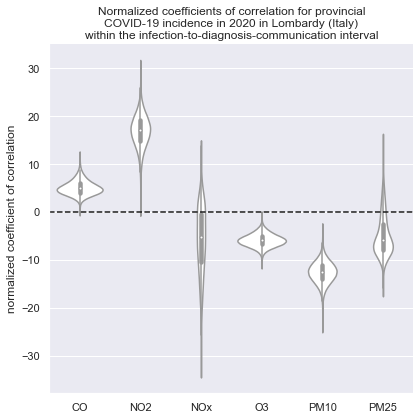

In [225]:
g = sns.catplot(
    kind='violin',
    data=coeff_samples2_df,
    x='x', y='normalized',
    color='white', saturation=1,
    aspect=1, height=6,
)
ax = g.axes.flat[0]
ax.axhline(0, color='k', ls='--')
ax.set(
    ylabel='normalized coefficient of correlation',
    xlabel=None,
    title="Normalized coefficients of correlation for provincial\n"
    "COVID-19 incidence in 2020 in Lombardy (Italy)\n"
    "within the infection-to-diagnosis-communication interval"
)
g.fig.tight_layout()
g.fig.savefig(f"images/all_coefficients_normalized.png")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'x'

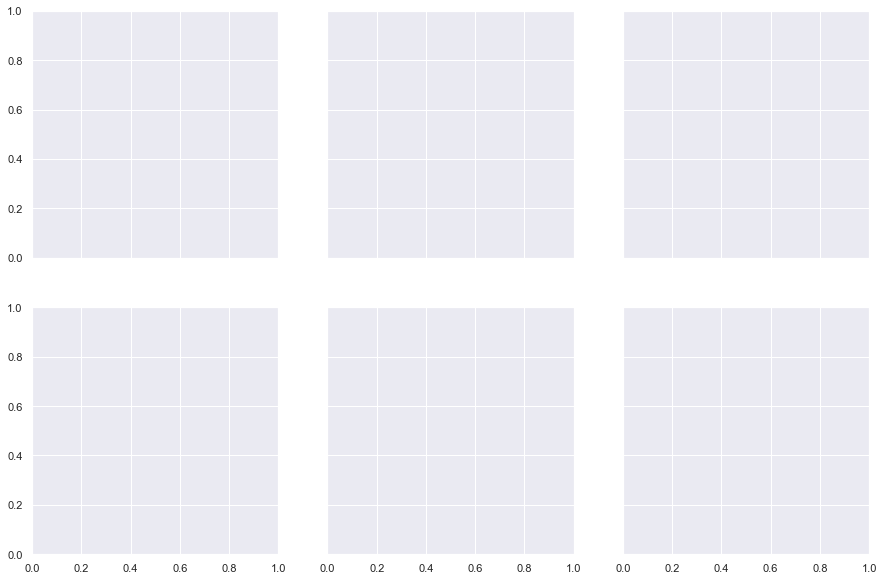

In [208]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for i, x in enumerate(res2_df.x.unique()):
    _df = res2_df[res2_df.x==x]
    for s in _df['shift'].unique():
        __df = _df[_df['shift']==s]
        fit = __df.fit.values[0]
        truths = __df.y.values[0]
        predictions = fit.predict()
        ax.flat[i].plot(truths, predictions, marker='.', ms=1, color='k', ls='none', alpha=.01)
    _lim_min = np.min([ax.flat[i].get_xlim()[0], ax.flat[i].get_ylim()[0]])
    _lim_max = np.max([ax.flat[i].get_xlim()[1], ax.flat[i].get_ylim()[1]])
    ax.flat[i].axline(xy1=(_lim_min, _lim_min), slope=1, ls='--', color='r')
    ax.flat[i].set(
        xlim=(_lim_min, _lim_max),
        ylim=(_lim_min, _lim_max),
        title=x,
        xlabel='truths', ylabel='predictions'
    )
fig.suptitle('True versus models predicted values', y=.95)
fig.savefig('images/all_truths_predicted.png')
plt.show()